<span style="color: #03FFFF; font-family: Times New Roman; font-size: 2em;"> Attention Addends by Heads </span>
<br>
This notebook shows how to visualize the addends that self- or cross-attention add to the hidden states by heads.

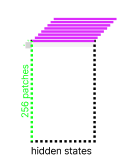

exampel for layer 9 attentions: take the 256 patches >> put them into a square >> sum the 160 feature activations for each attention head

In [1]:
%cd ..
from main import load, run
from interventions.ablate import AblationIntervention
from interventions.encoder import EncoderIntervention
from interventions.scale import ScalingIntervention
from util import encode_prompt
import matplotlib.pyplot as plt
import torch
import numpy as np

/share/u/imgr/nnsight-folder/collaborative_diffusion


In [2]:
model = load()
model._model.pipeline.safety_checker = None

Keyword arguments {'trust_remote_code': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

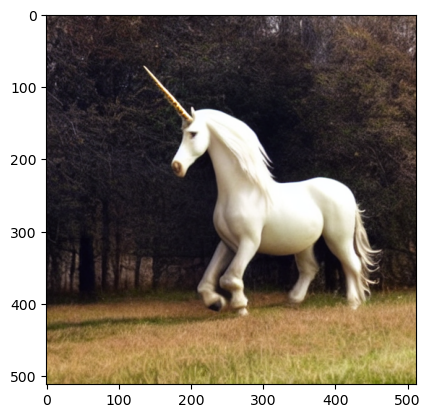

In [220]:
image = run(model, prompt="unicorn", seed=79)
plt.imshow(image)

Saving the attention outputs to access the heads

In [221]:
seed = 79
generator = torch.Generator()
generator = generator.manual_seed(seed)

with model.generate("unicorn", generator=generator, scan=False, validate=False) as tracer:
    
    #choose target attentions at layer : attn1 is self-attention, att2 is cross-attentions
    #attn = model.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn2
    #attn = model.unet.mid_block.attentions[0].transformer_blocks[0].attn2
    attn = model.unet.up_blocks[1].attentions[1].transformer_blocks[0].attn2
    
    head_addends = []

    for i in range(50):
        if i != 0:
            attn.next(propagate=True)

        thing = attn.to_out[0].input[0][0].save() #positonal arguments, keyword arguments for input

        head_addends.append(thing)

head_addends = torch.stack(head_addends)
print(head_addends.shape)

# plt.figure(figsize=(20, 20))
# for i in range(16):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(probs_np[i], cmap='cool')#, interpolation='nearest')
#    # plt.colorbar()
# plt.title
# plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([50, 2, 256, 1280])


question; isn't this after softmax? why is it npt within 0 - 1?

In [222]:
#To plot in activations in same scale for comparison across maps.
activation_avg = head_addends.cpu().mean().item()
activation_min = head_addends.cpu().min().item()
activation_max = head_addends.cpu().max().item()

print (f"Average activation: {activation_avg}")
print (f"Minimum activation: {activation_min}")
print (f"Maximum activation: {activation_max}")

s = int(np.sqrt(head_addends.shape[2]))
d = int(head_addends.shape[3]/8)
print(s,d)

Average activation: -0.006181779317557812
Minimum activation: -5.112273216247559
Maximum activation: 4.693711280822754
16 160


In [86]:
head_addends.abs().sum(dim=0)[0].reshape(s,s,8,d).sum(dim=3)[:,:,0].shape

torch.Size([32, 32])

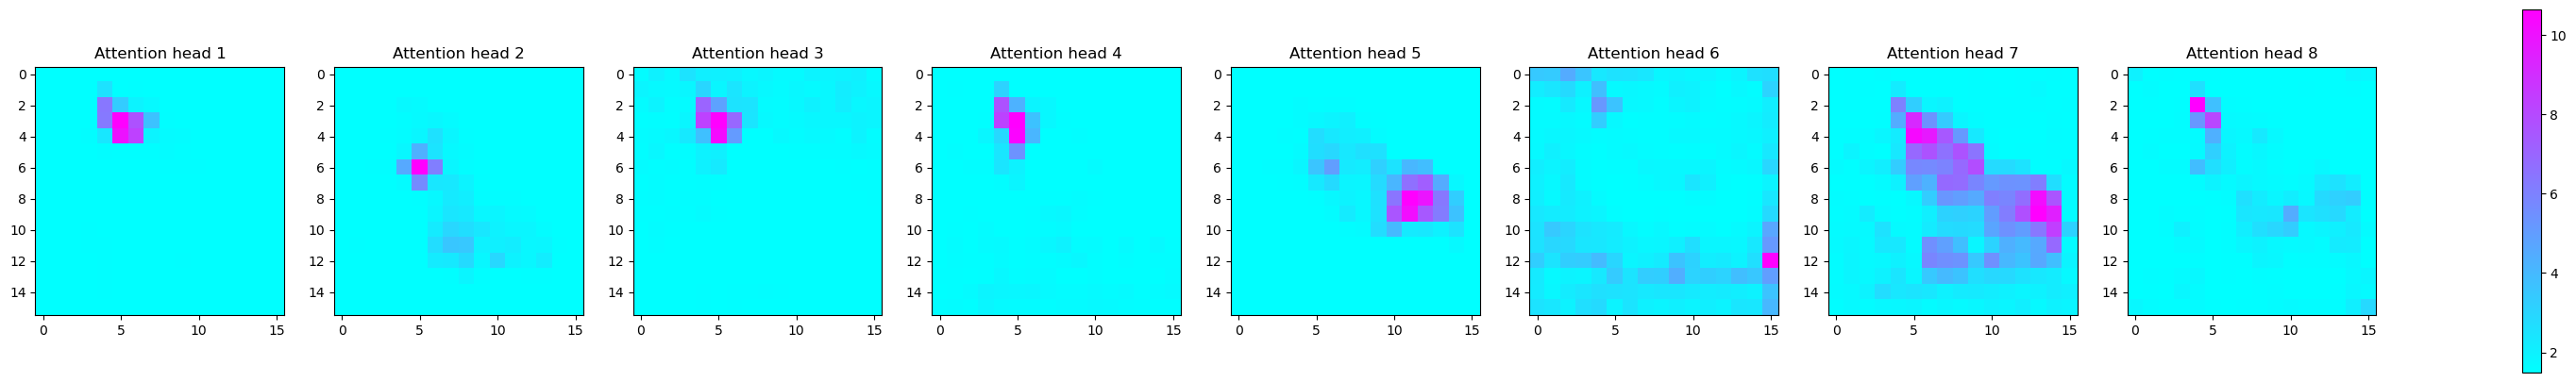

In [224]:
fig, axes = plt.subplots(1, 8, figsize=(40,10), dpi=100)

for i, ax in enumerate(axes.flat):
    im = ax.imshow(head_addends.abs().mean(dim=0)[1].reshape(s,s,8,d).sum(dim=3)[:,:,i].cpu(), cmap='cool')#, vmin=0, vmax = 1)
    ax.set_title(f"Attention head {i+1}")

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=.5)

#fig.suptitle(f"Attention head addends", fontsize=24)
plt.show()

Addends by Head after the MLP

In [226]:
seed = 79
generator = torch.Generator()
generator = generator.manual_seed(seed)

with model.generate("unicorn", generator=generator, scan=False, validate=False) as tracer:
    #choose target attentions at layer : attn1 is self-attention, att2 is cross-attentions
    #attn = model.unet.mid_block.attentions[0].transformer_blocks[0].attn1
    #attn = model.unet.down_blocks[1].attentions[0].transformer_blocks[0].attn1 
    attn = model.unet.up_blocks[1].attentions[1].transformer_blocks[0].attn2
    
    maps = []

    for i in range(25):
        if i != 0:
            attn.next(propagate=True)
        q = attn.to_q.output.cpu()
        k = attn.to_k.output.cpu()
        v = attn.to_v.output.cpu()

        q = tracer.apply(attn.head_to_batch_dim, False, q)
        k = tracer.apply(attn.head_to_batch_dim, False, k)
        v = tracer.apply(attn.head_to_batch_dim, False, v).save()

        attn_probs = tracer.apply(attn.get_attention_scores, False, q, k).save()
        # b: batch, t: tokens
        valued_attn_probs = torch.einsum("bth, bst -> bsth", v, attn_probs).save() #step between 
        valued_attn_probs_sum = valued_attn_probs.sum(dim=2).save() #addends
        
        valued_attn_probs_sum_cond = valued_attn_probs_sum[-8:] #only for the conditional image
        valued_attn_probs_sum_uncond = valued_attn_probs_sum[:8] #only for the conditional image
        
        #MLP WEIGHTS
        mlp_weights = attn.to_out[0].weight
        mlp_weights_byhead = mlp_weights.reshape(mlp_weights.shape[0],-1,8)
        
        #ADDENDUM BY HEAD AFTER MLP: h: heads, s: spatial (patches), d: head dim, o: residual dim
        addendum_byhead = torch.einsum("hsd, odh -> hso", valued_attn_probs_sum_cond, mlp_weights_byhead).save()
        addendum_byhead_uncond = torch.einsum("hsd, odh -> hso", valued_attn_probs_sum_uncond, mlp_weights_byhead).save()

print(addendum_byhead.shape)
print(addendum_byhead_uncond.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([8, 256, 1280])
torch.Size([8, 256, 1280])


Plot of the conditional attention head addends

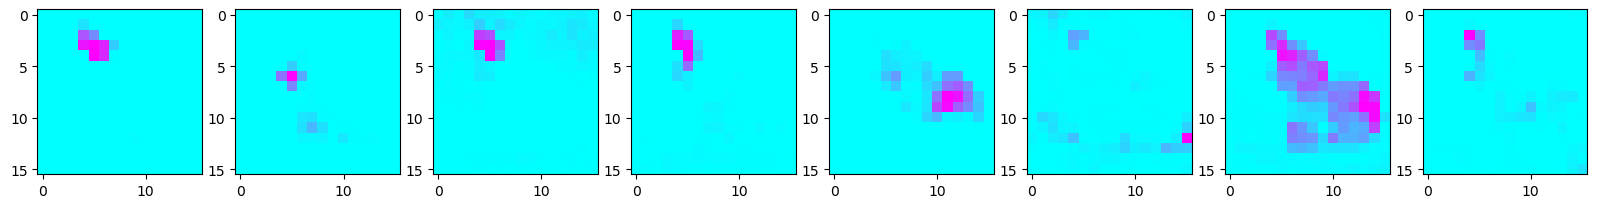

In [227]:
plt.figure(figsize=(20, 20))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(addendum_byhead[i].reshape((16,16,1280)).abs().sum(dim=2), cmap='cool')#, interpolation='nearest')
   # plt.colorbar()
plt.title
plt.show()

Plotting the unconditional attention head addends (Hmm... What does this tell us?)

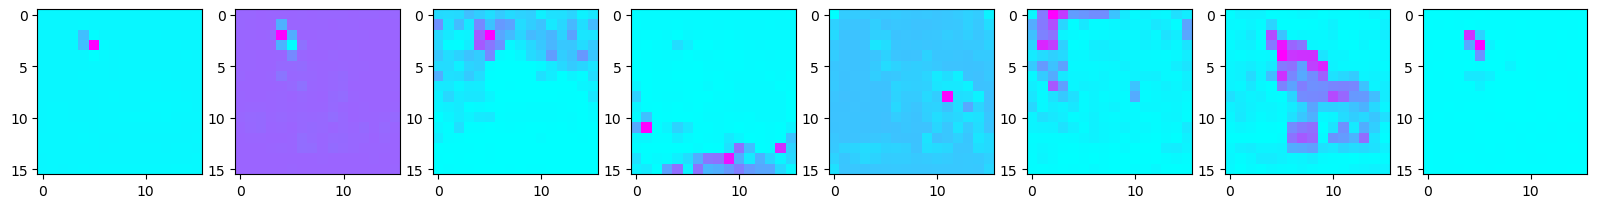

In [229]:
plt.figure(figsize=(20, 20))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(addendum_byhead_uncond[i].reshape((16,16,1280)).abs().sum(dim=2), cmap='cool')#, interpolation='nearest')
   # plt.colorbar()
plt.title
plt.show()